## **Abstract**

This workshop is at the crossroads of data science and environmental science. We will start with concise introduction to remote sensing. We will cover the basics of Earth Engine data types and how to analyze, and export Earth Engine NDVI data in a Jupyter environment using geemap.  and Google Earth Engine, followed by hands-on experience in utilizing Earth Engine data for collecting historical NDVI values, analyzing NDVI trends, and forecasting future NDVI patterns.

## **Terms**
-  **Remote Sensing** -> process of acquiring information about an object without coming into direct contact with it
-  **Normalized Difference Vegetation Index** -> metric for quantifying the health and density of vegetation using sensor data.
-  **Earth Engine** -> Google Earth Engine is a cloud-based platform for geospatial analysis and data visualizations
-  **geemap** -> Python package for interactive geospatial analysis and visualization with Google Earth Engine

## **Prerequisites**

To use geemap and the Earth Engine Python API, you must [register](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fcode.earthengine.google.com%2Fregister) for an Earth Engine account and follow the instructions [here](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fdocs.google.com%2Fdocument%2Fd%2F1ZGSmrNm6_baqd8CHt33kIBWOlvkh-HLr46bODgJN1h0%2Fedit%3Fusp%3Dsharing) to create a Cloud Project. Earth Engine is free for noncommercial and research use.

### **Install/upgrade  packages**


The geemap package is pre-installed in Google Colab and is updated to the latest minor or major release every few weeks.



In [ ]:
!pip install earthengine-api geetools

### **Local Installation**

Note that some geemap features do not work properly with Google Colab. If you are familiar with Anaconda or Miniconda, it is recommended to create a new conda environment to install geemap and its optional dependencies on your local computer.



```
conda create -n gee python=3.11
conda activate gee
conda install -c conda-forge mamba
mamba install -c conda-forge geemap pygis
```



In [ ]:
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Authenticate to the Earth Engine servers
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project="omdena-botswana")

## **Initialize/create interactive map**

In [ ]:
Map = geemap.Map(center=[-22, 17], zoom=6, height=600)

Map

Map(center=[-22, 17], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

## **Define Region of Interest**

## **Data Collection**
## **Earth Engine Collections**

In the Earth Engine Data Catalog, datasets can be of different types:
- Features which are geometric objects with a list of properties. For example, a watershed with some properties such as name and area, is an ee.Feature.

- Images which are like features, but may include several bands. For example, the ground elevation given by the USGS here is an ee.Image.
- Collections which are groups of features or images. For example, the Global Administrative Unit Layers giving administrative boundaries is a ee.FeatureCollection and the MODIS Land Surface Temperature dataset is an ee.ImageCollection.


In [ ]:
#bots = ee.FeatureCollection("FAO/GAUL/2015/level2") \
 #           .filter(ee.Filter.eq('ADM0_NAME', 'Botswana'))

In [ ]:
Map.draw_features

In [ ]:
roi = Map.draw_last_feature
Map.addLayer(roi)

#Map.addLayer(draw_last_feature, {}, 'Draw Last Feature')


In [ ]:
print(roi)

ee.Feature({
  "functionInvocationValue": {
    "functionName": "Feature",
    "arguments": {
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Polygon",
          "arguments": {
            "coordinates": {
              "constantValue": [
                [
                  [
                    14.396761,
                    -19.849394
                  ],
                  [
                    15.188027,
                    -26.529565
                  ],
                  [
                    18.133294,
                    -26.568877
                  ],
                  [
                    17.166192,
                    -19.87006
                  ],
                  [
                    14.396761,
                    -19.849394
                  ]
                ]
              ]
            },
            "geodesic": {
              "constantValue": false
            }
          }
        }
      }
    }
  }
})


In [ ]:
# Define the region of interest (Black Forest, Germany)
roi = ee.Geometry.Polygon([
                  [
                    14.396761,
                    -19.849394
                  ],
                  [
                    15.188027,
                    -26.529565
                  ],
                  [
                    18.133294,
                    -26.568877
                  ],
                  [
                    17.166192,
                    -19.87006
                  ],
                  [
                    14.396761,
                    -19.849394
                  ]
                ])

Moderate Resolution Imaging Spectroradiometer (MODIS) vegetation indices are designed to provide consistent spatial and temporal comparisons of vegetation conditions. Blue, red, and near-infrared reflectances

In [ ]:
# Define MODIS NDVI collection
modis_ndvi_collection = ee.ImageCollection('MODIS/006/MOD13A2') \
    .filterDate('2000-01-01', '2022-01-01') \
    .filterBounds(roi)\
    .select('NDVI')

In [ ]:
def scale_factor(image):
    # Scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

# Apply scale factor to the image collection
modis_ndvi_collection_scaled = modis_ndvi_collection.map(scale_factor)

In [ ]:
def calculate_mean_ndvi(image):
    mean_ndvi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=250,
        maxPixels=1e9
    )
    return image.set('date', image.date().format()).set('mean_ndvi', mean_ndvi.get('NDVI'))

In [ ]:
# Map the function over the scaled collection
modis_ndvi_with_mean = modis_ndvi_collection_scaled.map(calculate_mean_ndvi)

In [ ]:
# Convert the image collection to a list
modis_ndvi_list = modis_ndvi_with_mean.toList(modis_ndvi_with_mean.size())

In [ ]:
results = []

# Iterate over the image collection list
for i in range(modis_ndvi_list.size().getInfo()):
    image = ee.Image(modis_ndvi_list.get(i))
    date = image.get('date').getInfo()
    mean_ndvi = image.get('mean_ndvi').getInfo()
    results.append({'date': date, 'mean_ndvi': mean_ndvi})

In [ ]:
df = pd.DataFrame(results)

In [ ]:
df.to_csv("na-ndvi.csv")

## **Data Processing**


In [ ]:
df.head(10)

,date,mean_ndvi
0,2000-02-18T00:00:00,0.257928
1,2000-03-05T00:00:00,0.253703
2,2000-03-21T00:00:00,0.270564
3,2000-04-06T00:00:00,0.273531
4,2000-04-22T00:00:00,0.260036
5,2000-05-08T00:00:00,0.238452
6,2000-05-24T00:00:00,0.218671
7,2000-06-09T00:00:00,0.197257
8,2000-06-25T00:00:00,0.187653
9,2000-07-11T00:00:00,0.175901


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       503 non-null    object 
 1   mean_ndvi  503 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


### **Check for missing values**


In [ ]:
print(f'There are {df.isna().sum().sum()} missing values in the entire dataset.')

There are 0 missing values in the entire dataset.


### **Check for unique values**


In [ ]:
#determine the number of unique categories in each variable
df.nunique()

date         503
mean_ndvi    503
dtype: int64

### **Check if there values values > 1 and < -1**
-  NDVI values typically range from -1 to 1, with higher values indicating healthier and more dense vegetation. Water takes values closer to -1, green
vegetation takes values close to +1

    -  Values close to 1 indicate dense and healthy vegetation, such as forests or agricultural fields with lush green vegetation.
    -  Values around 0 indicate bare soil, rocks, or water bodies.
    -  Negative values usually represent features such as water bodies or clouds.


In [ ]:
invalid_values = df[(df['mean_ndvi'] > 1) | (df['mean_ndvi'] < -1)]

if len(invalid_values) > 0:
    print("There are invalid NDVI values:")
    print(invalid_values)
else:
    print("No invalid NDVI values found.")

No invalid NDVI values found.


### **Data Conversions and Feature Engineering**

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df['year'] = df['date'].dt.year
df['month']= df['date'].dt.month

In [ ]:
df.max()


date         2021-12-19 00:00:00
mean_ndvi               0.199404
year                        2021
month                         12
dtype: object


In [ ]:
df.head()

,mean_ndvi,year,month
date,,,
2000-02-18,0.257928,2000,2
2000-03-05,0.253703,2000,3
2000-03-21,0.270564,2000,3
2000-04-06,0.273531,2000,4
2000-04-22,0.260036,2000,4


In [ ]:
df.interpolate(method='polynomial', order = 1, inplace = True)

### **NDVI Time Series**

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['mean_ndvi'], marker='o', linestyle='-', color='g')
plt.title('NDVI Over Time')
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.grid(True)
plt.show()

KeyError: 'date'

<Figure size 1000x600 with 0 Axes>

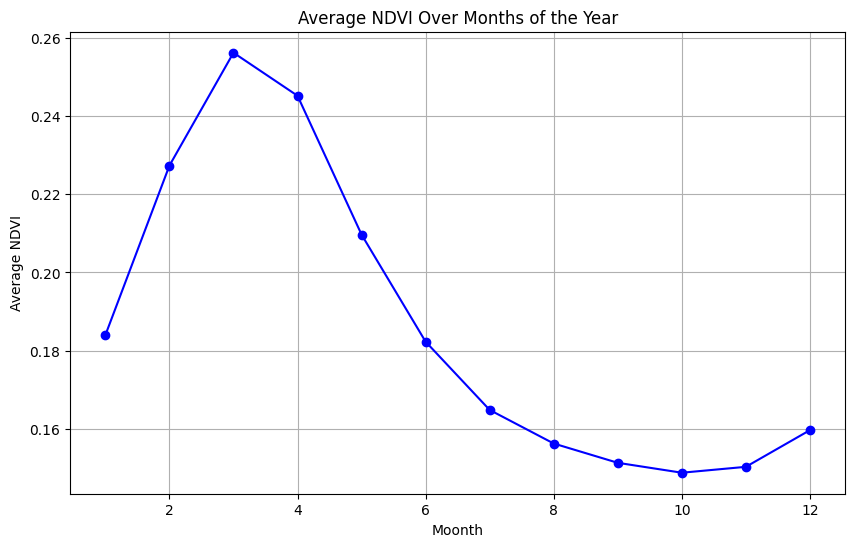

In [ ]:
average_ndvi = df.groupby('month')['mean_ndvi'].mean().reset_index()
average_ndvi['month'] = average_ndvi['month'].astype(int)
plt.figure(figsize=(10, 6))
plt.plot(average_ndvi['month'], average_ndvi['mean_ndvi'], marker='o', linestyle='-', color='b')
plt.xlabel('Moonth')
plt.ylabel('Average NDVI')
plt.title('Average NDVI Over Months of the Year')
plt.grid(True)
plt.show()

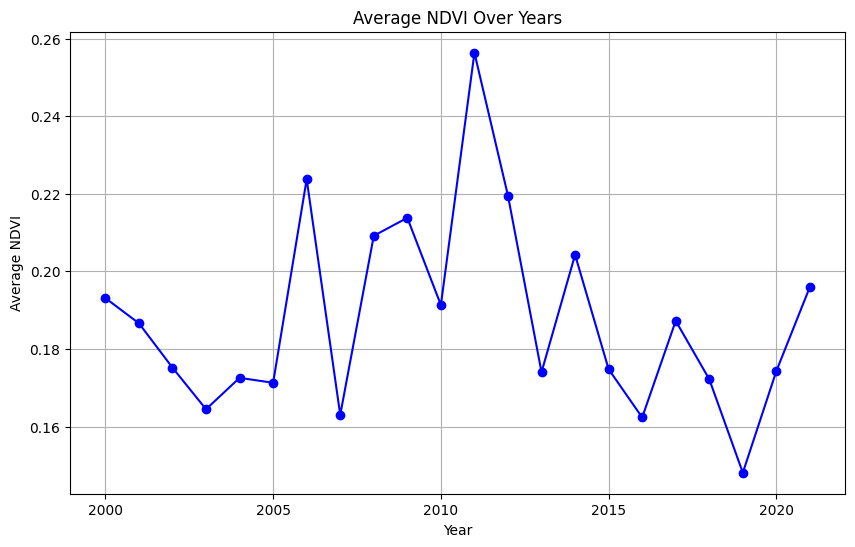

In [ ]:
average_ndvi = df.groupby('year')['mean_ndvi'].mean().reset_index()
average_ndvi['year'] = average_ndvi['year'].astype(int)
plt.figure(figsize=(10, 6))
plt.plot(average_ndvi['year'], average_ndvi['mean_ndvi'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average NDVI')
plt.title('Average NDVI Over Years')
plt.grid(True)
plt.show()

### **Seasonal decomposition**

Seasonal decomposition is a statistical technique used to break down a time series into its underlying components, including trend, seasonality, and residual (or error) components.

In [ ]:
df = df.set_index('date')

<Figure size 1100x700 with 0 Axes>

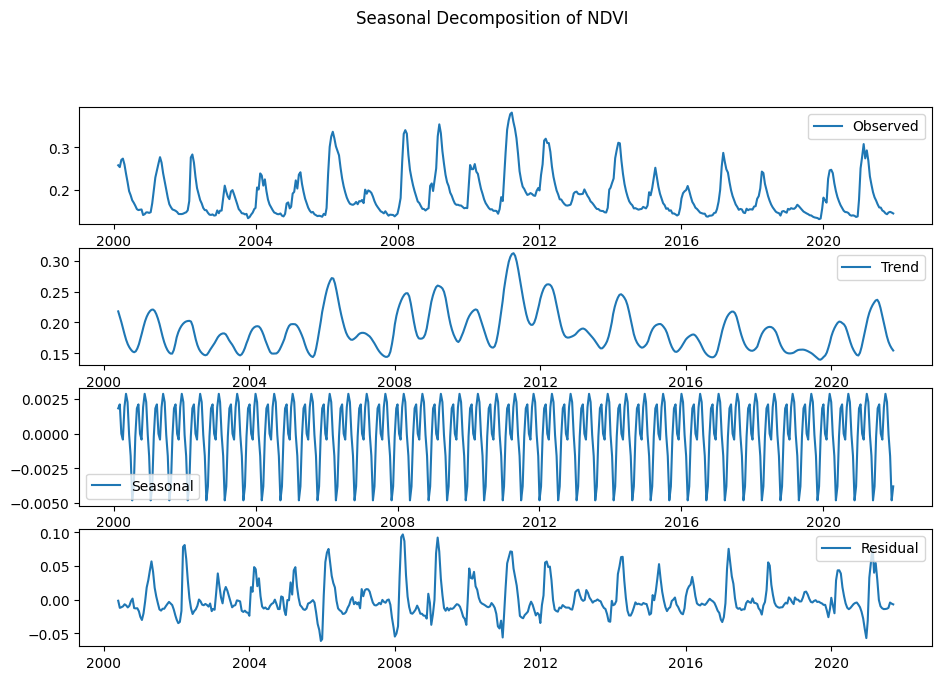

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Perform seasonal decomposition
result = seasonal_decompose(df['mean_ndvi'], model='additive', period=12)

# Plot the components
plt.figure(figsize=(11, 7))

# Plot the components
plt.figure(figsize=(11, 7))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.suptitle('Seasonal Decomposition of NDVI', y=1.02)
plt.show()

In [ ]:

# Find minimum and maximum NDVI for each year
#max_min = df.groupby('year')['mean_ndvi'].agg(['mean']).reset_index()
#max_min

### **Forecasting with Facebook Prophet**

Facebook Prophet is a popular open-source forecasting tool developed by Facebook.


Prophet is particularly well-suited for forecasting data with strong seasonal patterns and multiple seasonality. It can handle irregularly spaced time series data and automatically detect and incorporate holidays and other special events that may impact the forecast.

In [ ]:
from prophet import Prophet
import warnings
warnings.simplefilter('ignore')

In [ ]:
df = df.reset_index('date')

In [ ]:
df.rename(columns={'date': 'ds','mean_ndvi':'y'},inplace=True)


In [ ]:
df.head()

,ds,y,year,month
0,2000-02-18,0.113959,2000,2
1,2000-03-05,0.116427,2000,3
2,2000-03-21,0.127835,2000,3
3,2000-04-06,0.137759,2000,4
4,2000-04-22,0.137673,2000,4


In [ ]:
m = Prophet(interval_width=0.95)
model = m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gj80t59/z4xtt3p3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gj80t59/r_z3yhkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55786', 'data', 'file=/tmp/tmp4gj80t59/z4xtt3p3.json', 'init=/tmp/tmp4gj80t59/r_z3yhkb.json', 'output', 'file=/tmp/tmp4gj80t59/prophet_model613he04a/prophet_model-20240305231602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:16:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:16:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=1825)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2323,2026-12-14,0.090958,0.066379,0.114831
2324,2026-12-15,0.090938,0.068480,0.118289
2325,2026-12-16,0.090911,0.066717,0.116623
2326,2026-12-17,0.090879,0.064648,0.117673
2327,2026-12-18,0.090841,0.063682,0.118604


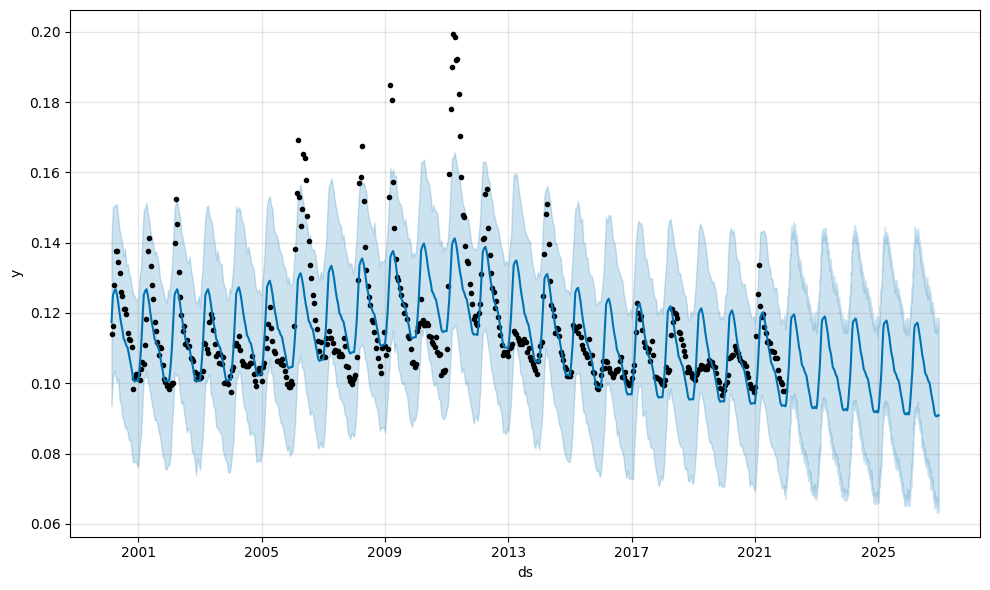

In [ ]:
fig1 = m.plot(forecast)

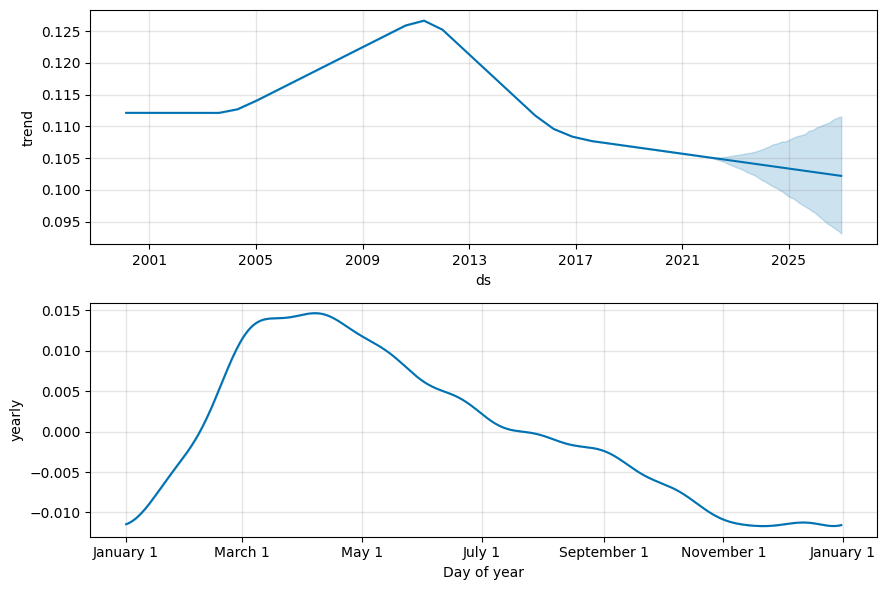

In [ ]:
fig2 = m.plot_components(forecast)


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)